In [1]:
!date

Thu Feb  3 11:47:36 PST 2022


# Expression MHC1-associated genes 
## - comparison between control and experiment datasets
Unfiltered data obtained from using kb with multimapping function. Ref genome includes WRE.

___

In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext blackcellmagic

In [3]:
import sys
import anndata
# import scvi

import scanpy as sc
import numpy as np
from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Custom violinplot code
from plotting_funcs import violinplot

import pandas as pd

sc.set_figure_params(figsize=(6, 6), frameon=False)
sc.settings.n_jobs=2

In [4]:
# set random seed
np.random.seed(926)

In [5]:
def nd(arr):
    """
    Funciton to transform numpy matrix to nd array.
    """
    return np.asarray(arr).reshape(-1)

___

# Load clustered and celltype assigned ctrl/experiment data

In [6]:
adata_exp = anndata.read('../../finchseq_data/exp_celltype.h5ad')

# Mark celltype and connectivity with "e" for experiment
adata_exp.obs["batch_g"] = "experiment"
adata_exp.obs["celltype_sep"] = adata_exp.obs["celltype"].astype(str) + "_e"
adata_exp.obs["connectivity_sep"] = adata_exp.obs["connectivity"].astype(str) + "_e"
adata_exp.obs.head()

,species,batch,n_counts_processed,batch_index,n_counts_raw,leiden,celltype,connectivity,batch_g,celltype_sep,connectivity_sep
barcode,,,,,,,,,,,
AAACCCACAAAGACGC-0,zebrafinch,experiment1,886.000000,0,886.000000,0,glutamatergic neurons 1,undefined 1,experiment,glutamatergic neurons 1_e,undefined 1_e
AAACCCACAGGACTAG-0,zebrafinch,experiment1,3870.000000,0,3870.000000,2,migrating neuroblasts 1,1,experiment,migrating neuroblasts 1_e,1_e
AAACCCACATATTCGG-0,zebrafinch,experiment1,2177.000000,0,2177.000000,8,astrocytes 1,2,experiment,astrocytes 1_e,2_e
AAACCCAGTATGTCAC-0,zebrafinch,experiment1,7167.000000,0,7167.000000,12,undefined 1,3,experiment,undefined 1_e,3_e
AAACCCATCATACAGC-0,zebrafinch,experiment1,4868.000488,0,4868.000488,7,microglia 2,4,experiment,microglia 2_e,4_e


In [7]:
adata_ctrl = anndata.read('../../finchseq_data/ctrl_celltype.h5ad')

# Mark celltype and connectivity with "c" for control
adata_ctrl.obs["batch_g"] = "control"
adata_ctrl.obs["celltype_sep"] = adata_ctrl.obs["celltype"].astype(str) + "_c"
adata_ctrl.obs["connectivity_sep"] = adata_ctrl.obs["connectivity"].astype(str) + "_c"
adata_ctrl.obs

,species,batch,n_counts_processed,batch_index,n_counts_raw,leiden,celltype,connectivity,batch_g,celltype_sep,connectivity_sep
barcode,,,,,,,,,,,
AAACCCAAGCACTGGA-0,zebrafinch,control1,483.000000,0,483.000000,15,mural cells 1,0,control,mural cells 1_c,0_c
AAACCCAAGCGTCAAG-0,zebrafinch,control1,946.000061,0,946.000061,12,microglia 1,1,control,microglia 1_c,1_c
AAACCCAAGGTCACAG-0,zebrafinch,control1,1068.000000,0,1068.000000,1,GABAergic neurons 1,2,control,GABAergic neurons 1_c,2_c
AAACCCAAGTCATTGC-0,zebrafinch,control1,1407.000000,0,1407.000000,9,astrocytes 2,3,control,astrocytes 2_c,3_c
AAACCCAAGTGCTACT-0,zebrafinch,control1,1060.000000,0,1060.000000,11,GABAergic neurons 2,4,control,GABAergic neurons 2_c,4_c
...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGCAAATAAGC-1,zebrafinch,control2,663.000000,1,663.000000,0,glutamatergic neurons 1,undefined 1,control,glutamatergic neurons 1_c,undefined 1_c
TTTGTTGCAGTTGTCA-1,zebrafinch,control2,1120.000000,1,1120.000000,9,astrocytes 2,3,control,astrocytes 2_c,3_c
TTTGTTGCATCGATAC-1,zebrafinch,control2,1177.000000,1,1177.000000,9,astrocytes 2,3,control,astrocytes 2_c,3_c


In [8]:
adata = adata_ctrl.concatenate(adata_exp, 
                             join='outer', 
                             batch_key='batch_index', 
                             batch_categories=None, 
                             uns_merge=None,
                             fill_value=np.nan)

In [9]:
# Create column containing general celltype assignment - ignoring cluster separation
adata.obs['celltype_g'] = adata.obs['celltype'].str.replace('\d+', '')
adata.obs.head()

/home/lauraluebbert/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,species,batch,n_counts_processed,batch_index,n_counts_raw,leiden,celltype,connectivity,batch_g,celltype_sep,connectivity_sep,celltype_g
barcode,,,,,,,,,,,,
AAACCCAAGCACTGGA-0-0,zebrafinch,control1,483.000000,0,483.000000,15,mural cells 1,0,control,mural cells 1_c,0_c,mural cells
AAACCCAAGCGTCAAG-0-0,zebrafinch,control1,946.000061,0,946.000061,12,microglia 1,1,control,microglia 1_c,1_c,microglia
AAACCCAAGGTCACAG-0-0,zebrafinch,control1,1068.000000,0,1068.000000,1,GABAergic neurons 1,2,control,GABAergic neurons 1_c,2_c,GABAergic neurons
AAACCCAAGTCATTGC-0-0,zebrafinch,control1,1407.000000,0,1407.000000,9,astrocytes 2,3,control,astrocytes 2_c,3_c,astrocytes
AAACCCAAGTGCTACT-0-0,zebrafinch,control1,1060.000000,0,1060.000000,11,GABAergic neurons 2,4,control,GABAergic neurons 2_c,4_c,GABAergic neurons


In [10]:
adata.obs.head()

,species,batch,n_counts_processed,batch_index,n_counts_raw,leiden,celltype,connectivity,batch_g,celltype_sep,connectivity_sep,celltype_g
barcode,,,,,,,,,,,,
AAACCCAAGCACTGGA-0-0,zebrafinch,control1,483.000000,0,483.000000,15,mural cells 1,0,control,mural cells 1_c,0_c,mural cells
AAACCCAAGCGTCAAG-0-0,zebrafinch,control1,946.000061,0,946.000061,12,microglia 1,1,control,microglia 1_c,1_c,microglia
AAACCCAAGGTCACAG-0-0,zebrafinch,control1,1068.000000,0,1068.000000,1,GABAergic neurons 1,2,control,GABAergic neurons 1_c,2_c,GABAergic neurons
AAACCCAAGTCATTGC-0-0,zebrafinch,control1,1407.000000,0,1407.000000,9,astrocytes 2,3,control,astrocytes 2_c,3_c,astrocytes
AAACCCAAGTGCTACT-0-0,zebrafinch,control1,1060.000000,0,1060.000000,11,GABAergic neurons 2,4,control,GABAergic neurons 2_c,4_c,GABAergic neurons


___

# Genes related to MHC Class 1
Regulation of CNS synapses by neuronal MHC class I https://pubmed.ncbi.nlm.nih.gov/17420446/

In [11]:
# MHCI associated genes
mhc_genes = [
    "_ENSTGUG00000017273.2",
    "_ENSTGUG00000028417.1",
    "_ENSTGUG00000004607.2",
    "_ENSTGUG00000010325.2",
    "CX3CR1_ENSTGUG00000018365.2",
    "_ENSTGUG00000024320.1",
#     "_ENSTGUG00000010847.2",
    "CD3E_ENSTGUG00000022317.1",
    "IFI30_ENSTGUG00000000388.2",
    "FGL2_ENSTGUG00000002746.2",
    "TAF7_ENSTGUG00000006593.2",
    "CALR_ENSTGUG00000014982.2",
    "_ENSTGUG00000015337.2",
    "CTSH_ENSTGUG00000009976.2",
    "PDIA3_ENSTGUG00000010220.2",
#     "CD8A_ENSTGUG00000010841.2",
    "IDE_ENSTGUG00000008951.2",
    "ATP5F1A_ENSTGUG00000001582.2",
    "ATP5F1B_ENSTGUG00000015620.2",
    ## Receptor for rescue signal canidate CX3C (expressed in microglia?)
    "CX3CR1_ENSTGUG00000018365.2"    # C-X3-C Motif Chemokine Ligand 1
]
mhc_gene_names = [
    "MHC1 F10 alpha chain-like 1",
    "MHC1 F10 alpha chain like 2",
    "Beta-2-microglobulin",
    "CCL3L3",
    "CX3CR1",
    "CX3CL1",
#     "MHC1 protein binding like",
    "CD3E",
    "IFI30",
    "Fibrinogen like 2",
    "TAF7",
    "Calreticulin",
    "Antigen peptide transporter like",
    "Cathepsin H",
    "PDIA3",
#     "CD8A",
    "IDE",
    "ATP5F1A",
    "ATP5F1B",
    ## Receptor for rescue signal canidate CX3C
    "CX3CR1_" 
]

#### Notes on MHC1 associated genes listed above:
novel gene (Zebra finch Gene)
ENSTGUG00000017273 RRCB01000109.1:1545781-1566436:1
Class I histocompatibility antigen, F10 alpha chain-like [Source:NCBI gene;Acc:115493126]
LOC100231469 (NCBI gene (formerly Entrezgene) record; description: class I histocompatibility antigen, F10 alpha chain-like,) is an external reference matched to Gene ENSTGUG00000017273

novel gene (Zebra finch Gene)
ENSTGUG00000028417 RRCB01000109.1:254090-279387:1
Class I histocompatibility antigen, F10 alpha chain-like [Source:NCBI gene;Acc:115493083]
LOC115493083 (NCBI gene (formerly Entrezgene) record; description: class I histocompatibility antigen, F10 alpha chain-like,) is an external reference matched to Gene ENSTGUG00000028417

novel gene (Zebra finch Gene)
ENSTGUG00000004607 10:4098707-4102774:-1
GO:0042612 (GO record; description: MHC class I protein complex,) is an external reference matched to Transcript ENSTGUT00000004794  
-- UniProtKB match:Beta-2-microglobulin

CD3E (Zebra finch Gene)
ENSTGUG00000022317 24:6524361-6530450:-1
CD3e molecule [Source:NCBI gene;Acc:115498349].

IFI30 (Zebra finch Gene)
ENSTGUG00000000388 28:3544686-3547884:1
IFI30 lysosomal thiol reductase [Source:HGNC Symbol;Acc:HGNC:5398]
GO:0042590 (GO record; description: antigen processing and presentation of exogenous peptide antigen via MHC class I,) is an external reference matched to Transcript ENSTGUT00000000403

TAF7 (Zebra finch Gene)
ENSTGUG00000006593 4A:18660736-18666314:1
TATA-box binding protein associated factor 7 like [Source:NCBI gene;Acc:100228159]
GO:0045344 (GO record; description: negative regulation of MHC class I biosynthetic process,) is an external reference matched to Transcript ENSTGUT00000006864

CALR (Zebra finch Gene)
ENSTGUG00000014982 30:3757974-3761873:1
Calreticulin [Source:NCBI gene;Acc:100190479]
GO:0042824 (GO record; description: MHC class I peptide loading complex,) is an external reference matched to Transcript ENSTGUT00000015593

novel gene (Zebra finch Gene)
ENSTGUG00000015337 RRCB01000090.1:2677018-2687645:1
Antigen peptide transporter 1-like [Source:NCBI gene;Acc:105760759]
GO:0002479 (GO record; description: antigen processing and presentation of exogenous peptide antigen via MHC class I, TAP-dependent,) is an external reference matched to Transcript ENSTGUT00000015946

CTSH (Zebra finch Gene)
ENSTGUG00000009976 10:21449104-21547116:-1
Cathepsin H [Source:HGNC Symbol;Acc:HGNC:2535]
GO:0030108 (GO record; description: HLA-A specific activating MHC class I receptor activity,) is an external reference matched to Transcript ENSTGUT00000010401

PDIA3 (Zebra finch Gene)
ENSTGUG00000010220 10:21775416-21783116:-1
Protein disulfide isomerase family A member 3 [Source:NCBI gene;Acc:101234078]
GO:0042824 (GO record; description: MHC class I peptide loading complex,) is an external reference matched to Transcript ENSTGUT00000010675

IDE (Zebra finch Gene)
ENSTGUG00000008951 6:19632451-19686491:1
Insulin degrading enzyme [Source:NCBI gene;Acc:100232369]
GO:0019885 (GO record; description: antigen processing and presentation of endogenous peptide antigen via MHC class I,) is an external reference matched to Transcript ENSTGUT00000036510

ATP5F1A (Zebra finch Gene)
ENSTGUG00000001582 Z:40984572-41030045:1
ATP synthase F1 subunit alpha [Source:NCBI gene;Acc:751975]
GO:0042288 (GO record; description: MHC class I protein binding,) is an external reference matched to Transcript ENSTGUT00000032148

ATP5F1B (Zebra finch Gene)
ENSTGUG00000015620 29:1469203-1601380:-1
ATP synthase F1 subunit beta [Source:NCBI gene;Acc:100221153]
GO:0042288 (GO record; description: MHC class I protein binding,) is an external reference matched to Transcript ENSTGUT00000016243

### Heatmaps

In [12]:
# vmin = 0
# vmax = [70, 13, 62, 100, 4, 15, 35, 27, 85, 11, 25, 8, 8, 16, 11, 26, 65, 4]
# size = 5

# for i, gene in enumerate(mhc_genes):
#     fig, axs = plt.subplots(figsize=(15,4), ncols=3)

#     condition = ["control", "experiment"]
#     color_map = "Reds"

#     sc.pl.umap(adata[np.char.startswith(nd(adata.obs.batch.values).astype(str), condition[0])], size=size, color=gene, title="Control - {}".format(mhc_gene_names[i], condition[0]), vmax=vmax[i], vmin=vmin, color_map=color_map, use_raw=True, show=False, ax=axs[0])
#     sc.pl.umap(adata[np.char.startswith(nd(adata.obs.batch.values).astype(str), condition[1])], size=size, color=gene, title="TetX - {}".format(mhc_gene_names[i], condition[1]), vmax=vmax[i], vmin=vmin, color_map=color_map, use_raw=True, show=False, ax=axs[1])
#     sc.pl.umap(adata, color="celltype", show=False, ax=axs[2])

___

# Violin plots

Split experiment and control data into separate AnnData objects for plotting:

In [13]:
adata_exp = adata[adata.obs.batch_g=="experiment"]
adata_ctrl = adata[adata.obs.batch_g=="control"]

___

# MHC1-associated genes

In [14]:
# genes = mhc_genes
# labels = mhc_gene_names
# celltypes = np.sort(adata.obs.celltype.values.unique())

# violinplot(genes, labels, celltypes, "MHC1-associated_genes", fold_change_min=1.5, figsize=(10,10))

____

# Microglia activation

Activated microglia produce free oxygen radicals and nitric oxide. They also express NMDA receptor agonists, and various proteases and cytokines.  
References:  
https://www.sciencedirect.com/science/article/pii/S1347861315001772?via%3Dihub  
https://www.sciencedirect.com/science/article/pii/S0165017307000550?via%3Dihub  

In [15]:
act_micro_markers = [
    ## Neurotoxic markers
    # Free oxygen radicals production
    "NOX1_ENSTGUG00000021927.1",      # NADPH oxidase (NOX) is a multicomponent enzyme complex that, upon activation, produces the highly reactive free radical superoxide
    "NOX3_ENSTGUG00000011124.2",
    "NOX4_ENSTGUG00000012893.2",
    # Nitric oxide production
    "NOS1_ENSTGUG00000010372.2",      # Nitric Oxide Synthase 1
    "NOS2_ENSTGUG00000008604.2",
    "NOS3_ENSTGUG00000019554.1",
    "_ENSTGUG00000027710.1",          # Nitric Oxide Synthase 1 Adaptor Protein    
    # Pro-inflammatory genes found in DE gene analysis
    "_ENSTGUG00000010325.2",
    "IFI6_ENSTGUG00000021692.1",  
    # Possible NMDAR agonsits found in DE gene analysis
    "SRGN_ENSTGUG00000003885.2",      # Serglycin; Might activate NMDARs https://jneuroinflammation.biomedcentral.com/articles/10.1186/s12974-019-1504-6
    
    ## Neuroprotective markers
    "TGFBI_ENSTGUG00000001216.2",
    "TGFBRAP1_ENSTGUG00000009752.2",
    "TGFBR1_ENSTGUG00000006726.2",   # Who receives the TGFB1 signal?
    
    ## Rescue signal canidate CX3C and its receptor
    "_ENSTGUG00000024320.1",         # C-X3-C motif chemokine ligand 1
    "CX3CR1_ENSTGUG00000018365.2",   # C-X3-C motif chemokine receptor 1
    
    # From Masuda et al JPS 2015
    "IRF1_ENSTGUG00000001375.2",
    "IRF8_ENSTGUG00000004127.2",
    "TLR2_ENSTGUG00000005181.2",
    "IL1B_ENSTGUG00000003368.2"
]
    
act_micro_names = [
    ## Neurotoxic markers
    # Free oxygen radicals production
    "NOX1",
    "NOX3",
    "NOX4",
    # Nitric oxide production
    "NOS1",
    "NOS2",
    "NOS3",
    "NOS1AP",
    # Pro-inflammatory genes found in DE gene analysis
    "CCL3L3",
    "IFI6",
    # Possible NMDAR agonsits found in DE gene analysis    
    "SRGN",
    
    ## Neuroprotective markers
    "TGFBI",
    "TGFBRAP1",
    "TGFBR1",
    
    ## Rescue signal canidate CX3C and its receptor
    "CX3C",
    "CX3CR1",
    
    # From Masuda et al JPS 2015
    "IRF1",
    "IRF8",
    "TLR2",
    "IL1B"
]

In [16]:
# adata_mglia = adata[np.char.startswith(nd(adata.obs.celltype.values).astype(str), "microglia")]
# adata_mglia

In [17]:
# adata.var[adata.var.index.str.contains("CTSS")]

ValueError: zero-size array to reduction operation minimum which has no identity

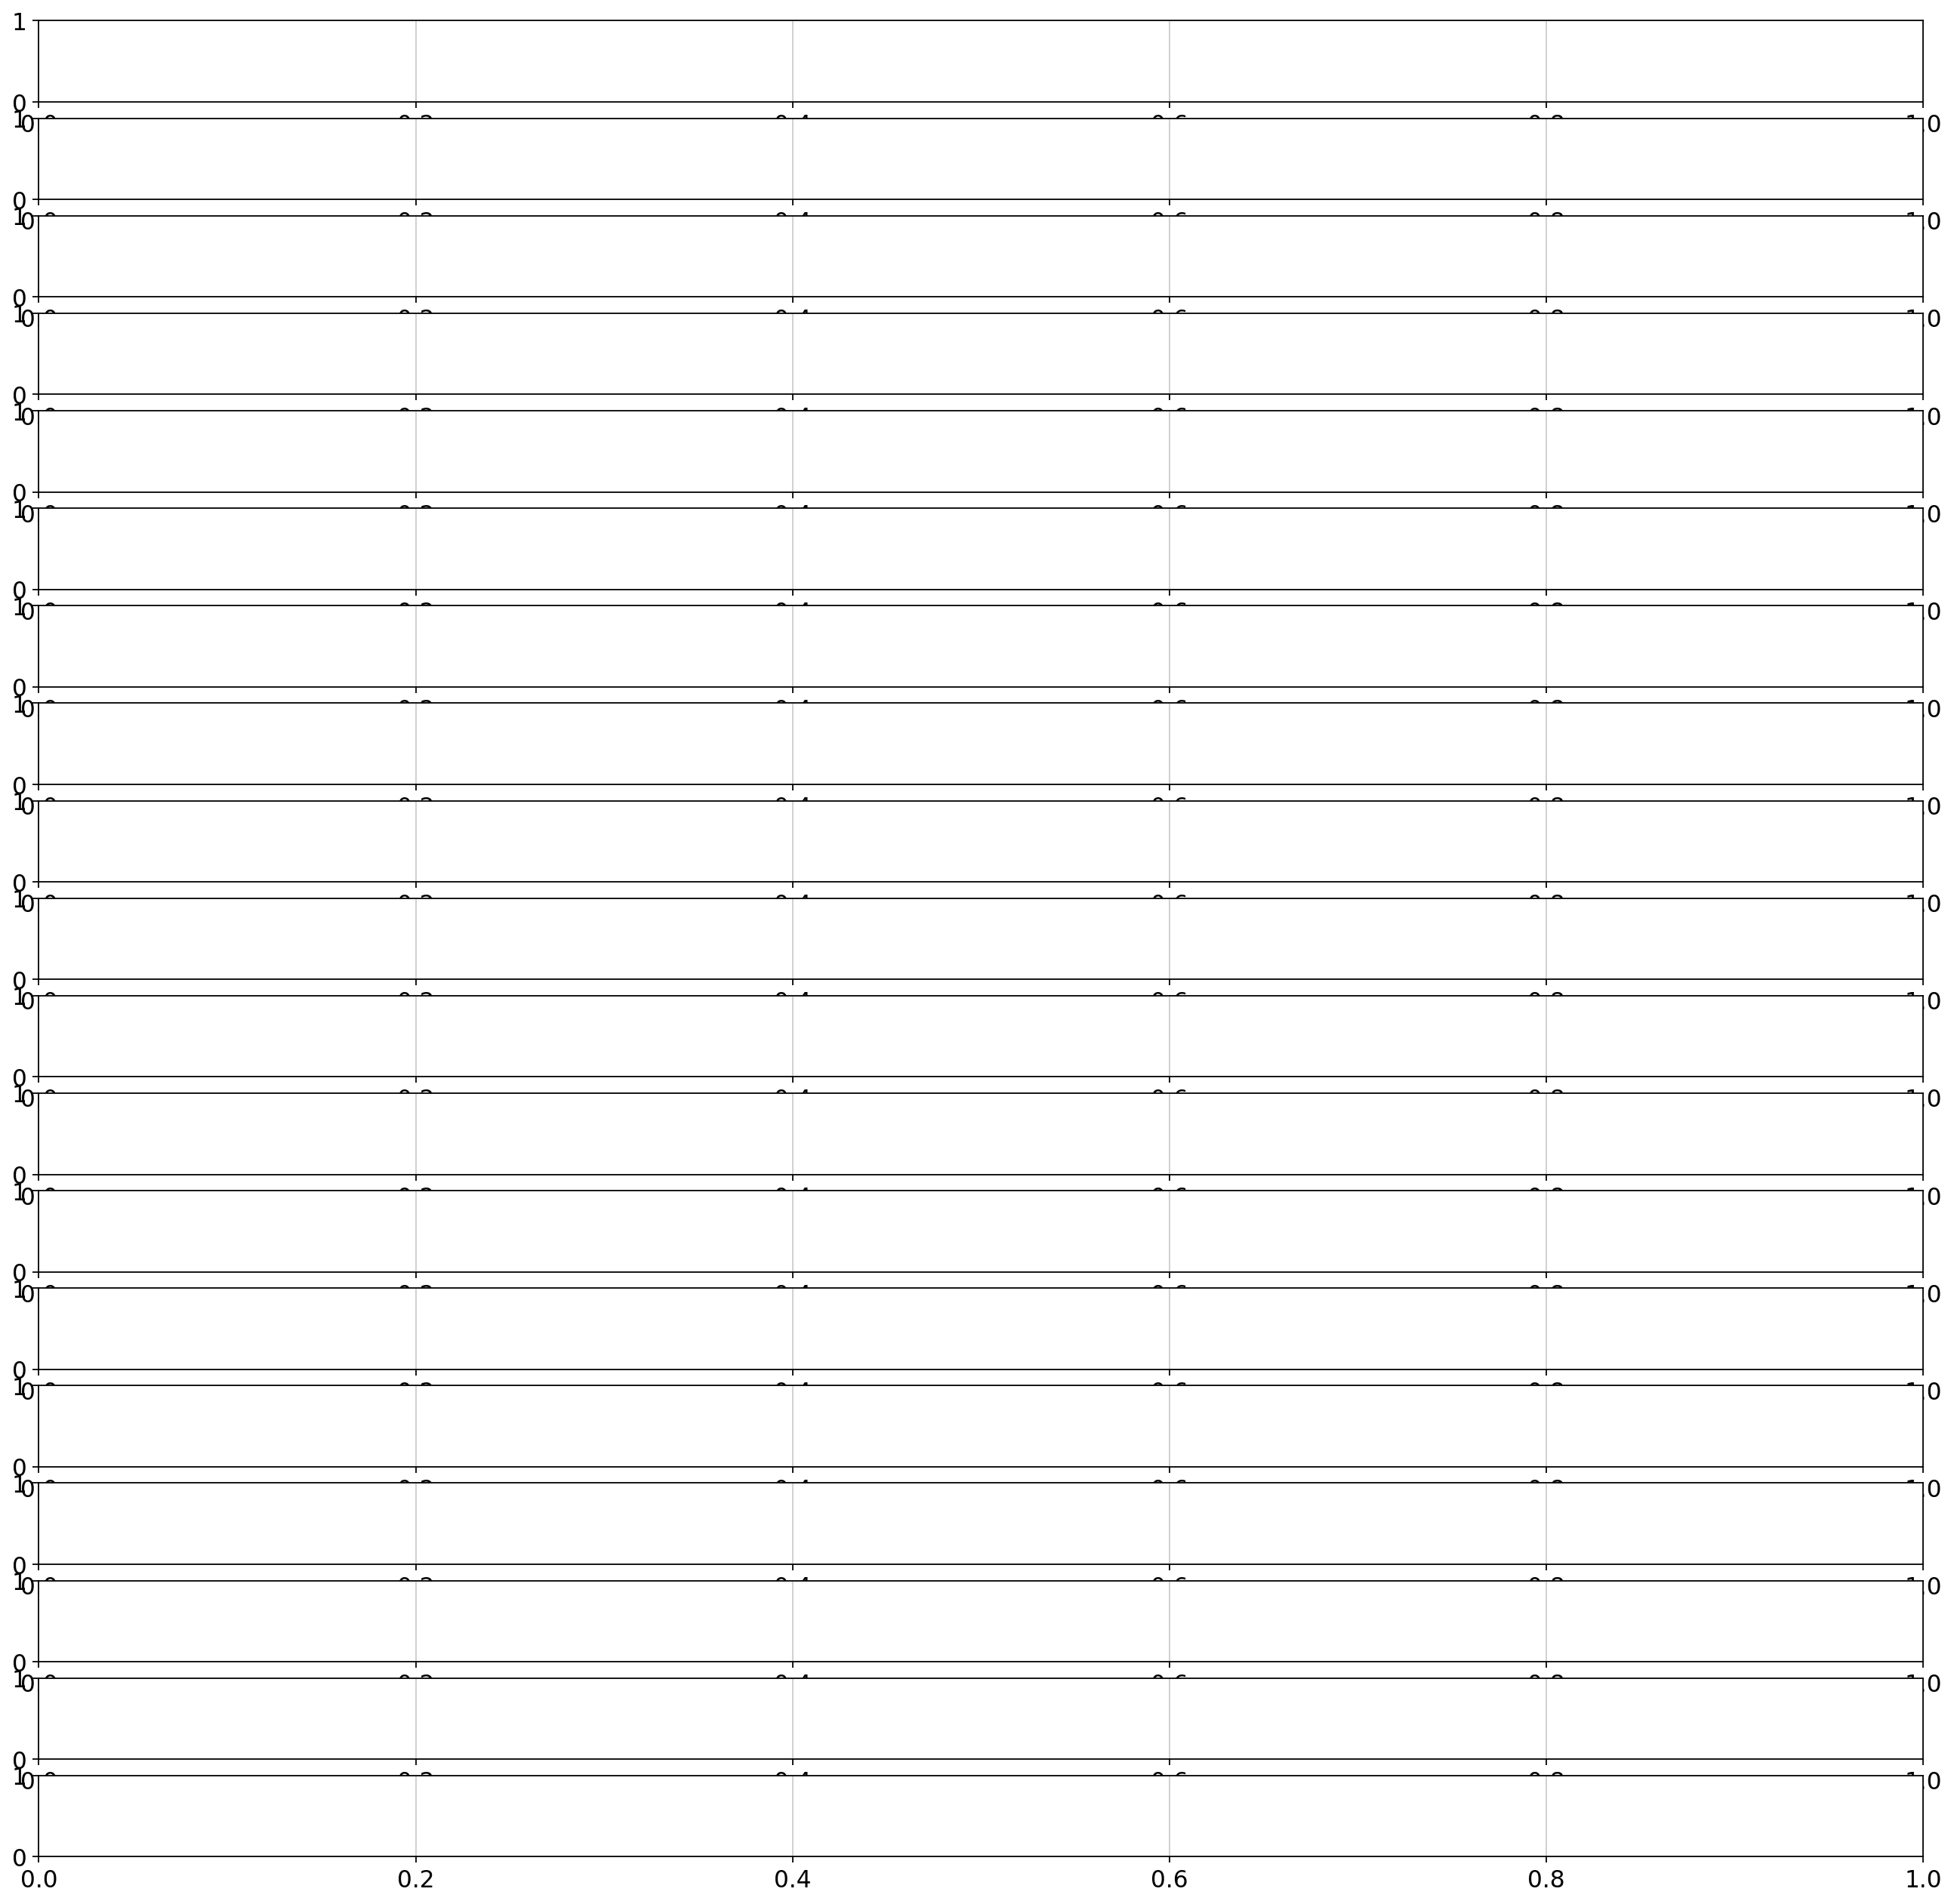

In [18]:
genes = act_micro_markers
labels = act_micro_names
celltypes = np.sort(np.unique(adata.obs.celltype_g.values))

violinplot(
    adata_exp,
    adata_ctrl,
    genes,
    labels,
    celltypes,
    fig_name="microglia_activation_genes_sep",
    alpha=0.05,
    fold_change_min=2,
    figsize=(20,20),
)

Showing only subset of genes and celltypes from above:

In [ ]:
act_micro_markers2 = [
    # Pro-inflammatory genes found in DE gene analysis
    "_ENSTGUG00000010325.2",
    "IFI6_ENSTGUG00000021692.1",  
    # Possible NMDAR agonsits found in DE gene analysis
    "SRGN_ENSTGUG00000003885.2",      # Serglycin; Might activate NMDARs https://jneuroinflammation.biomedcentral.com/articles/10.1186/s12974-019-1504-6
    
    ## Neuroprotective markers
    "TGFBI_ENSTGUG00000001216.2",
    
    ## Receptor for rescue signal canidate CX3C
    "CX3CR1_ENSTGUG00000018365.2",    # C-X3-C Motif Chemokine Ligand 1
    
    # From Masuda et al JPS 2015
    "IRF1_ENSTGUG00000001375.2",
    "TLR2_ENSTGUG00000005181.2",
]
    
act_micro_names2 = [
    # Pro-inflammatory genes found in DE gene analysis
    "CCL3L3",
    "IFI6",
    # Possible NMDAR agonsits found in DE gene analysis    
    "SRGN",
    
    ## Neuroprotective markers
    "TGFBI",
    
    ## Receptor for rescue signal canidate CX3C
    "CX3CR1",
    
    # From Masuda et al JPS 2015
    "IRF1",
    "TLR2",
]

In [ ]:
genes = act_micro_markers2
labels = act_micro_names2
celltypes = ["microglia "]

violinplot(
    adata_exp,
    adata_ctrl,
    genes,
    labels,
    celltypes,
    "microglia_activation_genes_short_sep",
    fold_change_min=1.5,
    figsize=(2.5, 10),
)